# params

In [1]:
batch_size = 32
epochs = 100
num_workers = 4

# mnist

In [2]:
import torchvision.datasets as datasets
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision import transforms
import torch

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

mnist_train_dataset = datasets.MNIST(root='data/pytorch/MNIST', train=True, download=True,
                                     transform=transform)
mnist_valid_dataset = datasets.MNIST(root='data/pytorch/MNIST', train=True, download=True,
                                     transform=transforms)
mnist_test_dataset = datasets.MNIST(root='data/pytorch/MNIST', train=False, transform=transform)

indices = list(range(len(mnist_train_dataset)))
validation_size = 5000
train_idx, valid_idx = indices[validation_size:], indices[:validation_size]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

mnist_train_loader = DataLoader(
    mnist_train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers
)

mnist_valid_loader = DataLoader(
    mnist_valid_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers
)

mnist_test_loader = DataLoader(
    mnist_test_dataset,
    batch_size=batch_size,
    num_workers=num_workers
)


# mnist_train_all = (mnist_train_dataset.train_data[5000:].reshape(55000, 28, 28, 1))
# mnist_concat = torch.cat((mnist_train_all, mnist_train_all, mnist_train_all), 3)
# print(mnist_test_dataset.test_labels.shape, mnist_test_dataset.test_labels)


def one_hot_embedding(labels, num_classes=10):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes)
    return y[labels]


# print(one_hot_embedding(mnist_test_dataset.test_labels))

# print(mnist_concat.shape)


# def test():
    # print(mnist_train_loader.shape)
    # print(len(train_sampler), len(mnist_test_loader), len(valid_sampler))
    # print(len(mnist_train_loader), len(mnist_valid_loader), len(mnist_test_loader))
    # for i, train_data in enumerate(mnist_train_loader):
    #     img, label = train_data
    #     print(img.shape)
    # for i in range(1):
    #     # for batch_idx, (inputs, labels) in enumerate(train_loader):
    #     #     print(i, batch_idx, labels, len(labels))
    # mnist_train_all = (mnist_train_dataset.train_data[5000:].reshape(55000, 28, 28, 1))
    # mnist_concat = torch.cat((mnist_train_all, mnist_train_all, mnist_train_all), 3)
    # print(mnist_concat.shape)
    # print(list(mnist_train_dataset.train_data[5000:].size()))
    # print(mnist_train_dataset.train_data.float().mean()/255)
    # print(mnist_train_dataset.train_data.float().std()/255)
    # for batch_idx, (train_data, test_data) in enumerate(zip(mnist_train_loader, mnist_valid_loader)):
    #     train_image, train_label = train_data
    #     test_image, test_label = test_data
    #     print(train_image.shape)
    #     # print(train_label, len(train_label))
    #     # print(test_label, len(test_label))
    #     # exit()

# test()

100%|██████████| 9912422/9912422 [00:00<00:00, 113971318.49it/s]


Extracting data/pytorch/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data/pytorch/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111337953.88it/s]

Extracting data/pytorch/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data/pytorch/MNIST/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 35632761.41it/s]


Extracting data/pytorch/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data/pytorch/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2283141.03it/s]

Extracting data/pytorch/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/pytorch/MNIST/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# mnistm

In [3]:
import torchvision.datasets as datasets
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision import transforms
import torch.utils.data as data
import torch
import os
import errno
from PIL import Image

# MNIST-M
class MNISTM(data.Dataset):
    """`MNIST-M Dataset."""

    url = "https://github.com/VanushVaswani/keras_mnistm/releases/download/1.0/keras_mnistm.pkl.gz"

    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'mnist_m_train.pt'
    test_file = 'mnist_m_test.pt'

    def __init__(self,
                 root, mnist_root="data",
                 train=True,
                 transform=None, target_transform=None,
                 download=False):
        """Init MNIST-M dataset."""
        super(MNISTM, self).__init__()
        self.root = os.path.expanduser(root)
        self.mnist_root = os.path.expanduser(mnist_root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if self.train:
            self.train_data, self.train_labels = \
                torch.load(os.path.join(self.root,
                                        self.processed_folder,
                                        self.training_file))
        else:
            self.test_data, self.test_labels = \
                torch.load(os.path.join(self.root,
                                        self.processed_folder,
                                        self.test_file))

    def __getitem__(self, index):
        """Get images and target for data loader.

        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        # print(type(img))
        img = Image.fromarray(img.squeeze().numpy(), mode='RGB')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        """Return size of dataset."""
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root,
                                           self.processed_folder,
                                           self.training_file)) and \
               os.path.exists(os.path.join(self.root,
                                           self.processed_folder,
                                           self.test_file))

    def download(self):
        """Download the MNIST data."""
        # import essential packages
        from six.moves import urllib
        import gzip
        import pickle
        from torchvision import datasets

        # check if dataset already exists
        if self._check_exists():
            return

        # make data dirs
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        # download pkl files
        print('Downloading ' + self.url)
        filename = self.url.rpartition('/')[2]
        file_path = os.path.join(self.root, self.raw_folder, filename)
        if not os.path.exists(file_path.replace('.gz', '')):
            data = urllib.request.urlopen(self.url)
            with open(file_path, 'wb') as f:
                f.write(data.read())
            with open(file_path.replace('.gz', ''), 'wb') as out_f, \
                    gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        # process and save as torch files
        print('Processing...')

        # load MNIST-M images from pkl file
        with open(file_path.replace('.gz', ''), "rb") as f:
            mnist_m_data = pickle.load(f, encoding='bytes')
        mnist_m_train_data = torch.ByteTensor(mnist_m_data[b'train'])
        mnist_m_test_data = torch.ByteTensor(mnist_m_data[b'test'])

        # get MNIST labels
        mnist_train_labels = datasets.MNIST(root=self.mnist_root,
                                            train=True,
                                            download=True).train_labels
        mnist_test_labels = datasets.MNIST(root=self.mnist_root,
                                           train=False,
                                           download=True).test_labels

        # save MNIST-M dataset
        training_set = (mnist_m_train_data, mnist_train_labels)
        test_set = (mnist_m_test_data, mnist_test_labels)
        with open(os.path.join(self.root,
                               self.processed_folder,
                               self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.root,
                               self.processed_folder,
                               self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('MNISTM Done!')


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.29730626, 0.29918741, 0.27534935),
                                                     (0.32780124, 0.32292358, 0.32056796))
                                ])

mnistm_train_dataset = MNISTM(root='data/pytorch/MNIST-M', train=True, download=True,
                              transform=transform)
mnistm_valid_dataset = MNISTM(root='data/pytorch/MNIST-M', train=True, download=True,
                              transform=transform)
mnistm_test_dataset = MNISTM(root='data/pytorch/MNIST-M', train=False, transform=transform)

indices = list(range(len(mnistm_train_dataset)))
validation_size = 5000
train_idx, valid_idx = indices[validation_size:], indices[:validation_size]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

mnistm_train_loader = DataLoader(
    mnistm_train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers
)

mnistm_valid_loader = DataLoader(
    mnistm_valid_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers
)

mnistm_test_loader = DataLoader(
    mnistm_test_dataset,
    batch_size=batch_size,
    num_workers=num_workers
)

# print(mnistm_train_dataset.train_data[5000:].shape)
# mnistm_concat = (mnistm_train_dataset.train_data[5000:])


# def test():
#     print(mnistm_train_dataset.train_data[5000:].shape)
#     print((mnistm_train_dataset.train_data[5000:].size()))
#
#     print(len(train_sampler), len(mnistm_test_loader), len(valid_sampler))
#     print(len(mnistm_train_loader), len(mnistm_valid_loader), len(mnistm_test_loader))
#     for i in range(1):
#         for batch_idx, (inputs, labels) in enumerate(mnistm_train_loader):
#             print(i, batch_idx, labels, len(labels))
#     for batch_idx, (train_data, test_data) in enumerate(zip(mnistm_train_loader, mnistm_valid_loader)):
#         train_image, train_label = train_data
#         test_image, test_label = test_data
#         print(train_label, len(train_label))
#         print(test_label, len(test_label))
#         exit()

# test()

Processing...


100%|██████████| 9912422/9912422 [00:00<00:00, 99758403.42it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 56817867.65it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29807692.53it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20011059.63it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


MNISTM Done!


# Utils

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Function
from sklearn.manifold import TSNE
import torch
import itertools
import os


class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None


def optimizer_scheduler(optimizer, p):
    """
    Adjust the learning rate of optimizer
    :param optimizer: optimizer for updating parameters
    :param p: a variable for adjusting learning rate
    :return: optimizer
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.01 / (1. + 10 * p) ** 0.75

    return optimizer


def one_hot_embedding(labels, num_classes=10):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes)
    return y[labels]


def save_model(encoder, classifier, discriminator, training_mode, save_name):
    print('Save models ...')

    save_folder = 'trained_models'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    torch.save(encoder.state_dict(), 'trained_models/encoder_' + str(training_mode) + '_' + str(save_name) + '.pt')
    torch.save(classifier.state_dict(), 'trained_models/classifier_' + str(training_mode) + '_' + str(save_name) + '.pt')

    if training_mode == 'dann':
        torch.save(discriminator.state_dict(), 'trained_models/discriminator_' + str(training_mode) + '_' + str(save_name) + '.pt')

    print('Model is saved !!!')


def plot_embedding(X, y, d, training_mode, save_name):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    y = list(itertools.chain.from_iterable(y))
    y = np.asarray(y)

    plt.figure(figsize=(10, 10))
    for i in range(len(d)):  # X.shape[0] : 1024
        # plot colored number
        if d[i] == 0:
            colors = (0.0, 0.0, 1.0, 1.0)
        else:
            colors = (1.0, 0.0, 0.0, 1.0)
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=colors,
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if save_name is not None:
        plt.title(save_name)

    save_folder = 'saved_plot'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    fig_name = 'saved_plot/' + str(training_mode) + '_' + str(save_name) + '.png'
    plt.savefig(fig_name)
    print('{} is saved'.format(fig_name))


def visualize(encoder, training_mode, save_name):
    # Draw 512 samples in test_data
    source_test_loader = mnist_test_loader
    target_test_loader = mnistm_test_loader

    # Get source_test samples
    source_label_list = []
    source_img_list = []
    for i, test_data in enumerate(source_test_loader):
        if i >= 16:  # to get only 512 samples
            break
        img, label = test_data
        label = label.numpy()
        img = img.cuda()
        img = torch.cat((img, img, img), 1)  # MNIST channel 1 -> 3
        source_label_list.append(label)
        source_img_list.append(img)

    source_img_list = torch.stack(source_img_list)
    source_img_list = source_img_list.view(-1, 3, 28, 28)

    # Get target_test samples
    target_label_list = []
    target_img_list = []
    for i, test_data in enumerate(target_test_loader):
        if i >= 16:
            break
        img, label = test_data
        label = label.numpy()
        img = img.cuda()
        target_label_list.append(label)
        target_img_list.append(img)

    target_img_list = torch.stack(target_img_list)
    target_img_list = target_img_list.view(-1, 3, 28, 28)

    # Stack source_list + target_list
    combined_label_list = source_label_list
    combined_label_list.extend(target_label_list)
    combined_img_list = torch.cat((source_img_list, target_img_list), 0)

    source_domain_list = torch.zeros(512).type(torch.LongTensor)
    target_domain_list = torch.ones(512).type(torch.LongTensor)
    combined_domain_list = torch.cat((source_domain_list, target_domain_list), 0).cuda()

    print("Extract features to draw T-SNE plot...")
    combined_feature = encoder(combined_img_list)  # combined_feature : 1024,2352

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
    dann_tsne = tsne.fit_transform(combined_feature.detach().cpu().numpy())

    print('Draw plot ...')
    save_name = save_name + '_' + str(training_mode)
    plot_embedding(dann_tsne, combined_label_list, combined_domain_list, training_mode, save_name)


def visualize_input():
    source_test_loader = mnist_test_loader
    target_test_loader = mnistm_test_loader

    # Get source_test samples
    source_label_list = []
    source_img_list = []
    for i, test_data in enumerate(source_test_loader):
        if i >= 16:  # to get only 512 samples
            break
        img, label = test_data
        label = label.numpy()
        img = img.cuda()
        img = torch.cat((img, img, img), 1)  # MNIST channel 1 -> 3
        source_label_list.append(label)
        source_img_list.append(img)

    source_img_list = torch.stack(source_img_list)
    source_img_list = source_img_list.view(-1, 3, 28, 28)

    # Get target_test samples
    target_label_list = []
    target_img_list = []
    for i, test_data in enumerate(target_test_loader):
        if i >= 16:
            break
        img, label = test_data
        label = label.numpy()
        img = img.cuda()
        target_label_list.append(label)
        target_img_list.append(img)

    target_img_list = torch.stack(target_img_list)
    target_img_list = target_img_list.view(-1, 3, 28, 28)

    # Stack source_list + target_list
    combined_label_list = source_label_list
    combined_label_list.extend(target_label_list)
    combined_img_list = torch.cat((source_img_list, target_img_list), 0)

    source_domain_list = torch.zeros(512).type(torch.LongTensor)
    target_domain_list = torch.ones(512).type(torch.LongTensor)
    combined_domain_list = torch.cat((source_domain_list, target_domain_list), 0).cuda()

    print("Extract features to draw T-SNE plot...")
    combined_feature = combined_img_list  # combined_feature : 1024,3,28,28
    combined_feature = combined_feature.view(1024, -1)  # flatten
    # print(type(combined_feature), combined_feature.shape)

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
    dann_tsne = tsne.fit_transform(combined_feature.detach().cpu().numpy())
    print('Draw plot ...')
    save_name = 'input_tsne_plot'
    plot_embedding(dann_tsne, combined_label_list, combined_domain_list, 'input', 'mnist_n_mnistM')


def get_free_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    # memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return 0

def set_model_mode(mode='train', models=None):
    for model in models:
        if mode == 'train':
            model.train()
        else:
            model.eval()

# Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Extractor(nn.Module):
    def __init__(self):
        super(Extractor, self).__init__()
        self.extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, x):
        x = self.extractor(x)
        x = x.view(-1, 3 * 28 * 28)
        return x


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=3 * 28 * 28, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=10)
        )

    def forward(self, x):
        x = self.classifier(x)
        return F.softmax(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(in_features=3 * 28 * 28, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=2)
        )

    def forward(self, input_feature, alpha):
        reversed_input = ReverseLayerF.apply(input_feature, alpha)
        x = self.discriminator(reversed_input)
        return F.softmax(x)

# Test

In [6]:
import torch
import numpy as np

def tester(encoder, classifier, discriminator, source_test_loader, target_test_loader, training_mode):
    print("Model test ...")

    encoder.cuda()
    classifier.cuda()
    set_model_mode('eval', [encoder, classifier])

    if training_mode == 'dann':
        discriminator.cuda()
        set_model_mode('eval', [discriminator])
        domain_correct = 0

    source_correct = 0
    target_correct = 0

    for batch_idx, (source_data, target_data) in enumerate(zip(source_test_loader, target_test_loader)):
        p = float(batch_idx) / len(source_test_loader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # 1. Source input -> Source Classification
        source_image, source_label = source_data
        source_image, source_label = source_image.cuda(), source_label.cuda()
        source_image = torch.cat((source_image, source_image, source_image), 1)  # MNIST convert to 3 channel
        source_feature = encoder(source_image)
        source_output = classifier(source_feature)
        source_pred = source_output.data.max(1, keepdim=True)[1]
        source_correct += source_pred.eq(source_label.data.view_as(source_pred)).cpu().sum()

        # 2. Target input -> Target Classification
        target_image, target_label = target_data
        target_image, target_label = target_image.cuda(), target_label.cuda()
        target_feature = encoder(target_image)
        target_output = classifier(target_feature)
        target_pred = target_output.data.max(1, keepdim=True)[1]
        target_correct += target_pred.eq(target_label.data.view_as(target_pred)).cpu().sum()

        if training_mode == 'dann':
            # 3. Combined input -> Domain Classificaion
            combined_image = torch.cat((source_image, target_image), 0)  # 64 = (S:32 + T:32)
            domain_source_labels = torch.zeros(source_label.shape[0]).type(torch.LongTensor)
            domain_target_labels = torch.ones(target_label.shape[0]).type(torch.LongTensor)
            domain_combined_label = torch.cat((domain_source_labels, domain_target_labels), 0).cuda()
            domain_feature = encoder(combined_image)
            domain_output = discriminator(domain_feature, alpha)
            domain_pred = domain_output.data.max(1, keepdim=True)[1]
            domain_correct += domain_pred.eq(domain_combined_label.data.view_as(domain_pred)).cpu().sum()

    if training_mode == 'dann':
        print("Test Results on DANN :")
        print('\nSource Accuracy: {}/{} ({:.2f}%)\n'
              'Target Accuracy: {}/{} ({:.2f}%)\n'
              'Domain Accuracy: {}/{} ({:.2f}%)\n'.
            format(
            source_correct, len(source_test_loader.dataset), 100. * source_correct.item() / len(source_test_loader.dataset),
            target_correct, len(target_test_loader.dataset), 100. * target_correct.item() / len(target_test_loader.dataset),
            domain_correct, len(source_test_loader.dataset) + len(target_test_loader.dataset), 100. * domain_correct.item() / (len(source_test_loader.dataset) + len(target_test_loader.dataset))
        ))
    else:
        print("Test results on source_only :")
        print('\nSource Accuracy: {}/{} ({:.2f}%)\n'
              'Target Accuracy: {}/{} ({:.2f}%)\n'.format(
            source_correct, len(source_test_loader.dataset), 100. * source_correct.item() / len(source_test_loader.dataset),
            target_correct, len(target_test_loader.dataset), 100. * target_correct.item() / len(target_test_loader.dataset)))

# Train

In [7]:
import torch
import numpy as np
import torch.optim as optim
import torch.nn as nn

# Source : 0, Target :1
source_test_loader = mnist_test_loader
target_test_loader = mnistm_test_loader


def source_only(encoder, classifier, source_train_loader, target_train_loader, save_name):
    print("Source-only training")
    classifier_criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(
        list(encoder.parameters()) +
        list(classifier.parameters()),
        lr=0.01, momentum=0.9)

    for epoch in range(epochs):
        print('Epoch : {}'.format(epoch))
        set_model_mode('train', [encoder, classifier])

        start_steps = epoch * len(source_train_loader)
        total_steps = epochs * len(target_train_loader)

        for batch_idx, (source_data, target_data) in enumerate(zip(source_train_loader, target_train_loader)):
            source_image, source_label = source_data
            p = float(batch_idx + start_steps) / total_steps

            source_image = torch.cat((source_image, source_image, source_image), 1)  # MNIST convert to 3 channel
            source_image, source_label = source_image.cuda(), source_label.cuda()  # 32

            optimizer = optimizer_scheduler(optimizer=optimizer, p=p)
            optimizer.zero_grad()

            source_feature = encoder(source_image)

            # Classification loss
            class_pred = classifier(source_feature)
            class_loss = classifier_criterion(class_pred, source_label)

            class_loss.backward()
            optimizer.step()
            if (batch_idx + 1) % 50 == 0:
                print('[{}/{} ({:.0f}%)]\tClass Loss: {:.6f}'.format(batch_idx * len(source_image), len(source_train_loader.dataset), 100. * batch_idx / len(source_train_loader), class_loss.item()))

        if (epoch + 1) % 10 == 0:
            tester(encoder, classifier, None, source_test_loader, target_test_loader, training_mode='source_only')
    save_model(encoder, classifier, None, 'source', save_name)
    visualize(encoder, 'source', save_name)


def dann(encoder, classifier, discriminator, source_train_loader, target_train_loader, save_name):
    print("DANN training")

    classifier_criterion = nn.CrossEntropyLoss().cuda()
    discriminator_criterion = nn.CrossEntropyLoss().cuda()

    optimizer = optim.SGD(
    list(encoder.parameters()) +
    list(classifier.parameters()) +
    list(discriminator.parameters()),
    lr=0.01,
    momentum=0.9)

    for epoch in range(epochs):
        print('Epoch : {}'.format(epoch))
        set_model_mode('train', [encoder, classifier, discriminator])

        start_steps = epoch * len(source_train_loader)
        total_steps = epochs * len(target_train_loader)

        for batch_idx, (source_data, target_data) in enumerate(zip(source_train_loader, target_train_loader)):

            source_image, source_label = source_data
            target_image, target_label = target_data

            p = float(batch_idx + start_steps) / total_steps
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            source_image = torch.cat((source_image, source_image, source_image), 1)

            source_image, source_label = source_image.cuda(), source_label.cuda()
            target_image, target_label = target_image.cuda(), target_label.cuda()
            combined_image = torch.cat((source_image, target_image), 0)

            optimizer = optimizer_scheduler(optimizer=optimizer, p=p)
            optimizer.zero_grad()

            combined_feature = encoder(combined_image)
            source_feature = encoder(source_image)

            # 1.Classification loss
            class_pred = classifier(source_feature)
            class_loss = classifier_criterion(class_pred, source_label)

            # 2. Domain loss
            domain_pred = discriminator(combined_feature, alpha)

            domain_source_labels = torch.zeros(source_label.shape[0]).type(torch.LongTensor)
            domain_target_labels = torch.ones(target_label.shape[0]).type(torch.LongTensor)
            domain_combined_label = torch.cat((domain_source_labels, domain_target_labels), 0).cuda()
            domain_loss = discriminator_criterion(domain_pred, domain_combined_label)

            total_loss = class_loss + domain_loss
            total_loss.backward()
            optimizer.step()

            if (batch_idx + 1) % 50 == 0:
                print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\tClass Loss: {:.6f}\tDomain Loss: {:.6f}'.format(
                    batch_idx * len(target_image), len(target_train_loader.dataset), 100. * batch_idx / len(target_train_loader), total_loss.item(), class_loss.item(), domain_loss.item()))

        if (epoch + 1) % 10 == 0:
            tester(encoder, classifier, discriminator, source_test_loader, target_test_loader, training_mode='dann')

    save_model(encoder, classifier, discriminator, 'source', save_name)
    visualize(encoder, 'source', save_name)

# Main

Running GPU : 0
Source-only training
Epoch : 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-5-5ea6f2a6f2c3>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


[1568/60000 (3%)]	Class Loss: 2.302197
[3168/60000 (6%)]	Class Loss: 2.301353
[4768/60000 (9%)]	Class Loss: 2.301336
[6368/60000 (12%)]	Class Loss: 2.298558
[7968/60000 (14%)]	Class Loss: 2.296515
[9568/60000 (17%)]	Class Loss: 2.292007
[11168/60000 (20%)]	Class Loss: 2.151260
[12768/60000 (23%)]	Class Loss: 1.990917
[14368/60000 (26%)]	Class Loss: 1.824315
[15968/60000 (29%)]	Class Loss: 1.752697
[17568/60000 (32%)]	Class Loss: 1.693865
[19168/60000 (35%)]	Class Loss: 1.628873
[20768/60000 (38%)]	Class Loss: 1.689252
[22368/60000 (41%)]	Class Loss: 1.507220
[23968/60000 (44%)]	Class Loss: 1.661531
[25568/60000 (46%)]	Class Loss: 1.556071
[27168/60000 (49%)]	Class Loss: 1.568343
[28768/60000 (52%)]	Class Loss: 1.606478
[30368/60000 (55%)]	Class Loss: 1.597251
[31968/60000 (58%)]	Class Loss: 1.657605
[33568/60000 (61%)]	Class Loss: 1.730018
[35168/60000 (64%)]	Class Loss: 1.612704
[36768/60000 (67%)]	Class Loss: 1.619692
[38368/60000 (70%)]	Class Loss: 1.554677
[39968/60000 (73%)]	Class

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-5-5ea6f2a6f2c3>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
<ipython-input-5-5ea6f2a6f2c3>:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


[1568/60000 (3%)]	Loss: 2.624572	Class Loss: 2.301872	Domain Loss: 0.322700
[3168/60000 (6%)]	Loss: 2.616039	Class Loss: 2.300068	Domain Loss: 0.315971
[4768/60000 (9%)]	Loss: 2.623739	Class Loss: 2.301893	Domain Loss: 0.321846
[6368/60000 (12%)]	Loss: 2.611885	Class Loss: 2.296568	Domain Loss: 0.315316
[7968/60000 (14%)]	Loss: 2.611290	Class Loss: 2.289105	Domain Loss: 0.322184
[9568/60000 (17%)]	Loss: 2.593588	Class Loss: 2.280043	Domain Loss: 0.313545
[11168/60000 (20%)]	Loss: 2.446436	Class Loss: 2.131442	Domain Loss: 0.314994
[12768/60000 (23%)]	Loss: 2.036807	Class Loss: 1.717966	Domain Loss: 0.318841
[14368/60000 (26%)]	Loss: 2.051293	Class Loss: 1.738030	Domain Loss: 0.313263
[15968/60000 (29%)]	Loss: 1.963020	Class Loss: 1.649750	Domain Loss: 0.313270
[17568/60000 (32%)]	Loss: 1.940748	Class Loss: 1.608689	Domain Loss: 0.332059
[19168/60000 (35%)]	Loss: 1.912796	Class Loss: 1.599281	Domain Loss: 0.313516
[20768/60000 (38%)]	Loss: 1.995528	Class Loss: 1.681925	Domain Loss: 0.31

KeyboardInterrupt: ignored

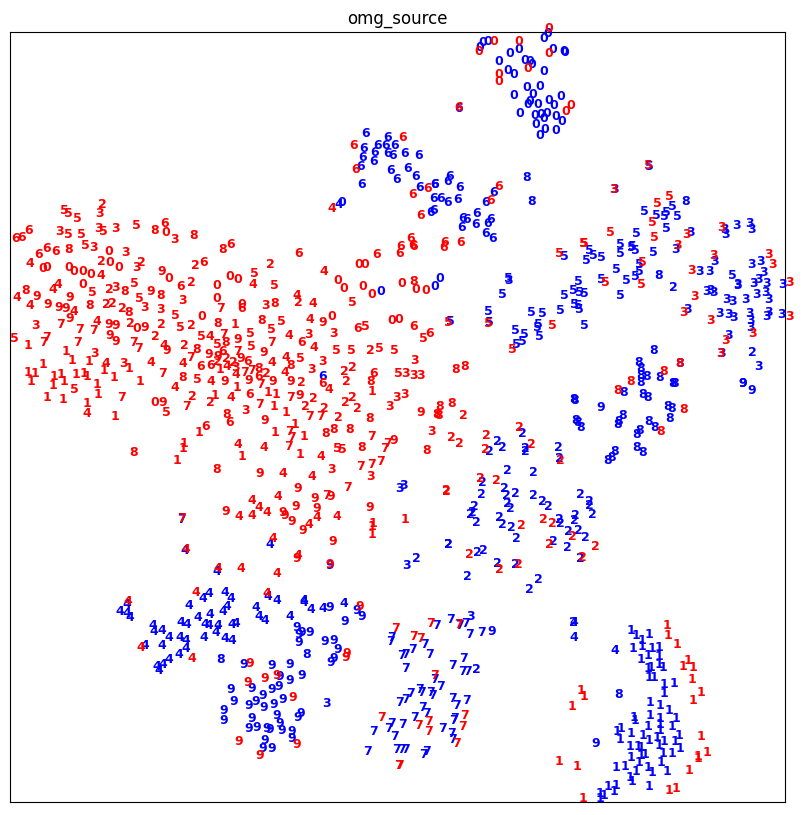

In [8]:
import torch

save_name = 'omg'

def main():
    source_train_loader = mnist_train_loader
    target_train_loader = mnistm_train_loader

    if torch.cuda.is_available():
        get_free_gpu()
        print('Running GPU : {}'.format(torch.cuda.current_device()))
        # encoder = Extractor().cuda()
        # classifier = Classifier().cuda()
        # discriminator = Discriminator().cuda()

        # source_only(encoder, classifier, source_train_loader, target_train_loader, save_name)

        encoder = Extractor().cuda()
        classifier = Classifier().cuda()
        discriminator = Discriminator().cuda()

        dann(encoder, classifier, discriminator, source_train_loader, target_train_loader, save_name)

    else:
        print("There is no GPU -_-!")


if __name__ == "__main__":
    main()

# Source only
Test results on source_only :

Source Accuracy: 9915/10000 (99.15%)
Target Accuracy: 6219/10000 (62.19%)

# DANN